# Image augmentation and transfer learning

In [177]:
from os import listdir, path, makedirs, environ
from os.path import join, isfile, isdir
from keras.utils import image_dataset_from_directory
from PIL import Image, ImageOps
import keras.utils as utils
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, RandomFlip, RandomZoom, RandomRotation, InputLayer, RandomBrightness,RandomContrast, Rescaling, MaxPooling2D, RandomCrop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ig, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random


from shutil import copy as cp, rmtree as rm
import matplotlib.pyplot as plot
import torch

environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=0"

#torch.cuda.is_available()


In [2]:
original_directory = './trainingData/'
subfolders = ['G', 'H', 'K', 'M']

image_gen = ig(
    rescale = 1./255,
    #rotation_range = 45,
    validation_split = 0.1,
    #brightness_range = [1,0.01]
)

G
H
K
M
{'G': 68, 'H': 48, 'K': 30, 'M': 41}


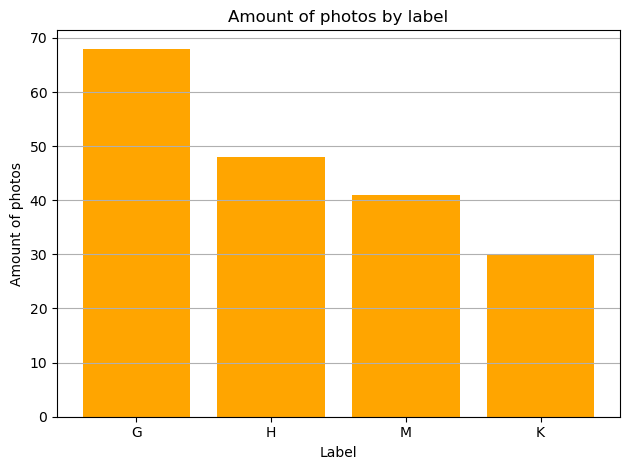

In [289]:
training_directory = "./training_dir"
validation_directory = "./validation_dir"
accepted_suffixes = ('.png', 'jpeg', 'jpg')
train_test_amt = 0.125

# Create train/test directories if they don't exist
makedirs(training_directory, exist_ok=True)
makedirs(validation_directory, exist_ok=True)

class_image_amounts = {}
for class_name in subfolders:
    print(class_name)
    class_dirname = join(original_directory, class_name)
    if isdir(class_dirname):
        if path.exists(training_directory) & path.exists(validation_directory):
            rm(training_directory)
            rm(validation_directory)
        makedirs(join(training_directory, class_name), exist_ok=True)
        makedirs(join(validation_directory, class_name), exist_ok=True)
        images = [image for image in listdir(class_dirname) if image.endswith(accepted_suffixes)]

        class_image_amounts[class_name] = len(images)
print(class_image_amounts)
class_image_amounts = sorted_dict_ascending = dict(sorted(class_image_amounts.items(),key=lambda x:x[1], reverse= True))

plot.bar(class_image_amounts.keys(),class_image_amounts.values(), color='orange')
plot.xlabel('Label')
plot.ylabel('Amount of photos')
plot.title('Amount of photos by label')
plot.grid(axis='y')
plot.tight_layout()

In [294]:
print(round(np.mean(list(class_image_amounts.values()))))
mean_img_amt = round(np.mean(list(class_image_amounts.values())))

47


G
59
30
H
42
30
K
26
30
4
current train_images ./trainingData/K30
current test images ./trainingData/K4
30
M
35
30


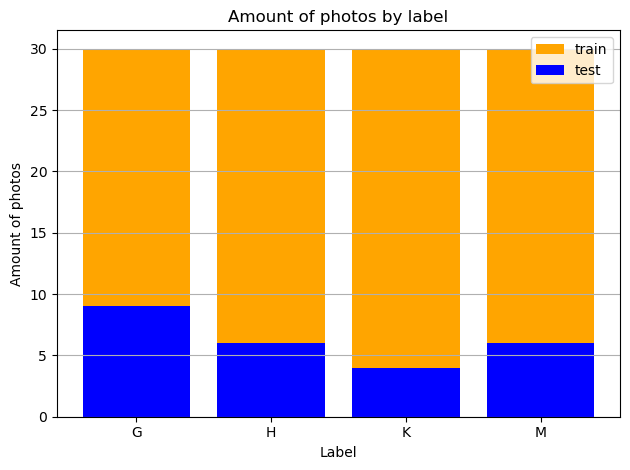

In [282]:

min_class_size = min(class_image_amounts.values())

tr_split = {}
ts_split = {}

for class_name in subfolders:
    print(class_name)
    class_dirname = join(original_directory, class_name)
    if isdir(class_dirname):
        makedirs(join(training_directory, class_name), exist_ok=True)
        makedirs(join(validation_directory, class_name), exist_ok=True)

        images = [image for image in listdir(class_dirname) if image.endswith(accepted_suffixes)]

        train_images, test_images = train_test_split(images, test_size=train_test_amt, random_state=42)
        
        print(len(train_images))
        print(min_class_size)

        if len(train_images) > min_class_size:
            train_images = random.sample(train_images, min_class_size)  
        tr_split[class_name] = len(train_images)

        if len(train_images) < min_class_size:
            additional_samples = min_class_size - len(train_images)
            print(additional_samples)
            oversampled_images = random.choices(train_images, k=additional_samples)
            train_images += oversampled_images
            print(f'current train_images {class_dirname}{len(train_images)}')
            print(f'current test images {class_dirname}{len(test_images)}')
            print(len(train_images))
        
        tr_split[class_name] = len(train_images)
        ts_split[class_name] = len(test_images)
        for i in train_images:
            cp(join(class_dirname,i), join(training_directory, class_name, i))
        for i in test_images:
            cp(join(class_dirname,i), join(validation_directory, class_name, i))

# G seems overrepresented - Needs to be balanced

tr_split = sorted_dict_ascending = dict(sorted(tr_split.items(),key=lambda x:x[1], reverse= True))
ts_split = sorted_dict_ascending = dict(sorted(ts_split.items(),key=lambda x:x[1], reverse= True))

plot.bar(tr_split.keys(),tr_split.values(), color='orange', label='train')
plot.bar(ts_split.keys(),ts_split.values(), color='blue', label = 'test')
plot.xlabel('Label')
plot.ylabel('Amount of photos')
plot.title('Amount of photos by label')
plot.legend()
plot.grid(axis='y')
plot.tight_layout()

In [272]:

batch_size = 32
shape = 128
image_shape = (shape,shape)
labels = 'inferred',
color_mode = 'rgb'

train_dataset = image_dataset_from_directory(
    training_directory,
    shuffle=True,
    batch_size=batch_size,
    image_size=image_shape,
    labels = 'inferred',
    pad_to_aspect_ratio = True,
    label_mode = 'categorical'

)

validation_dataset = image_dataset_from_directory(
    validation_directory,
    batch_size = batch_size,
    image_size = image_shape,
    labels = 'inferred',
    pad_to_aspect_ratio = True,
    label_mode = 'categorical'
)

train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))

validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))

Found 114 files belonging to 4 classes.
Found 36 files belonging to 4 classes.


## Model build

In [260]:
conv_filters = 32
kernel_size = (3,3)

optimizer = Adam(
    learning_rate = 0.0001,
    weight_decay = 0.0001
)

data_augmentation = Sequential([
    #RandomFlip('horizontal'),
    RandomZoom(0.01, 0.01),
    RandomRotation(0.001),
    #RandomCrop(100, 100),
    #RandomBrightness(0.01),
    RandomContrast(0.1)

])

#training_data_augmented = np.array([data_augmentation(image).numpy() for image in train_dataset])

conv_model = Sequential([
    InputLayer(shape=(shape,shape, 3)),
    data_augmentation,
    Conv2D(int((conv_filters/2)),kernel_size,activation='relu', name='Conv_1'),
    Conv2D(conv_filters,kernel_size,activation='relu' , name='Conv_2'),
    # Drops lower pixels from kernelled representation
    MaxPooling2D(name = 'Max_Pooling'),
    #MaxPooling2D(),
    Flatten(name='Flatten'),

    Dense(shape,activation='relu'),
    Dense(len(subfolders),activation='softmax', name='output')
]
)

In [261]:
conv_model.summary()

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_76 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 124, 124, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling (MaxPooling2D)      │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,750,756 (60.08 MB)

 Trainable params: 15,750,756 (60.08 MB)

 Non-trainable params: 0 (0.00 B)

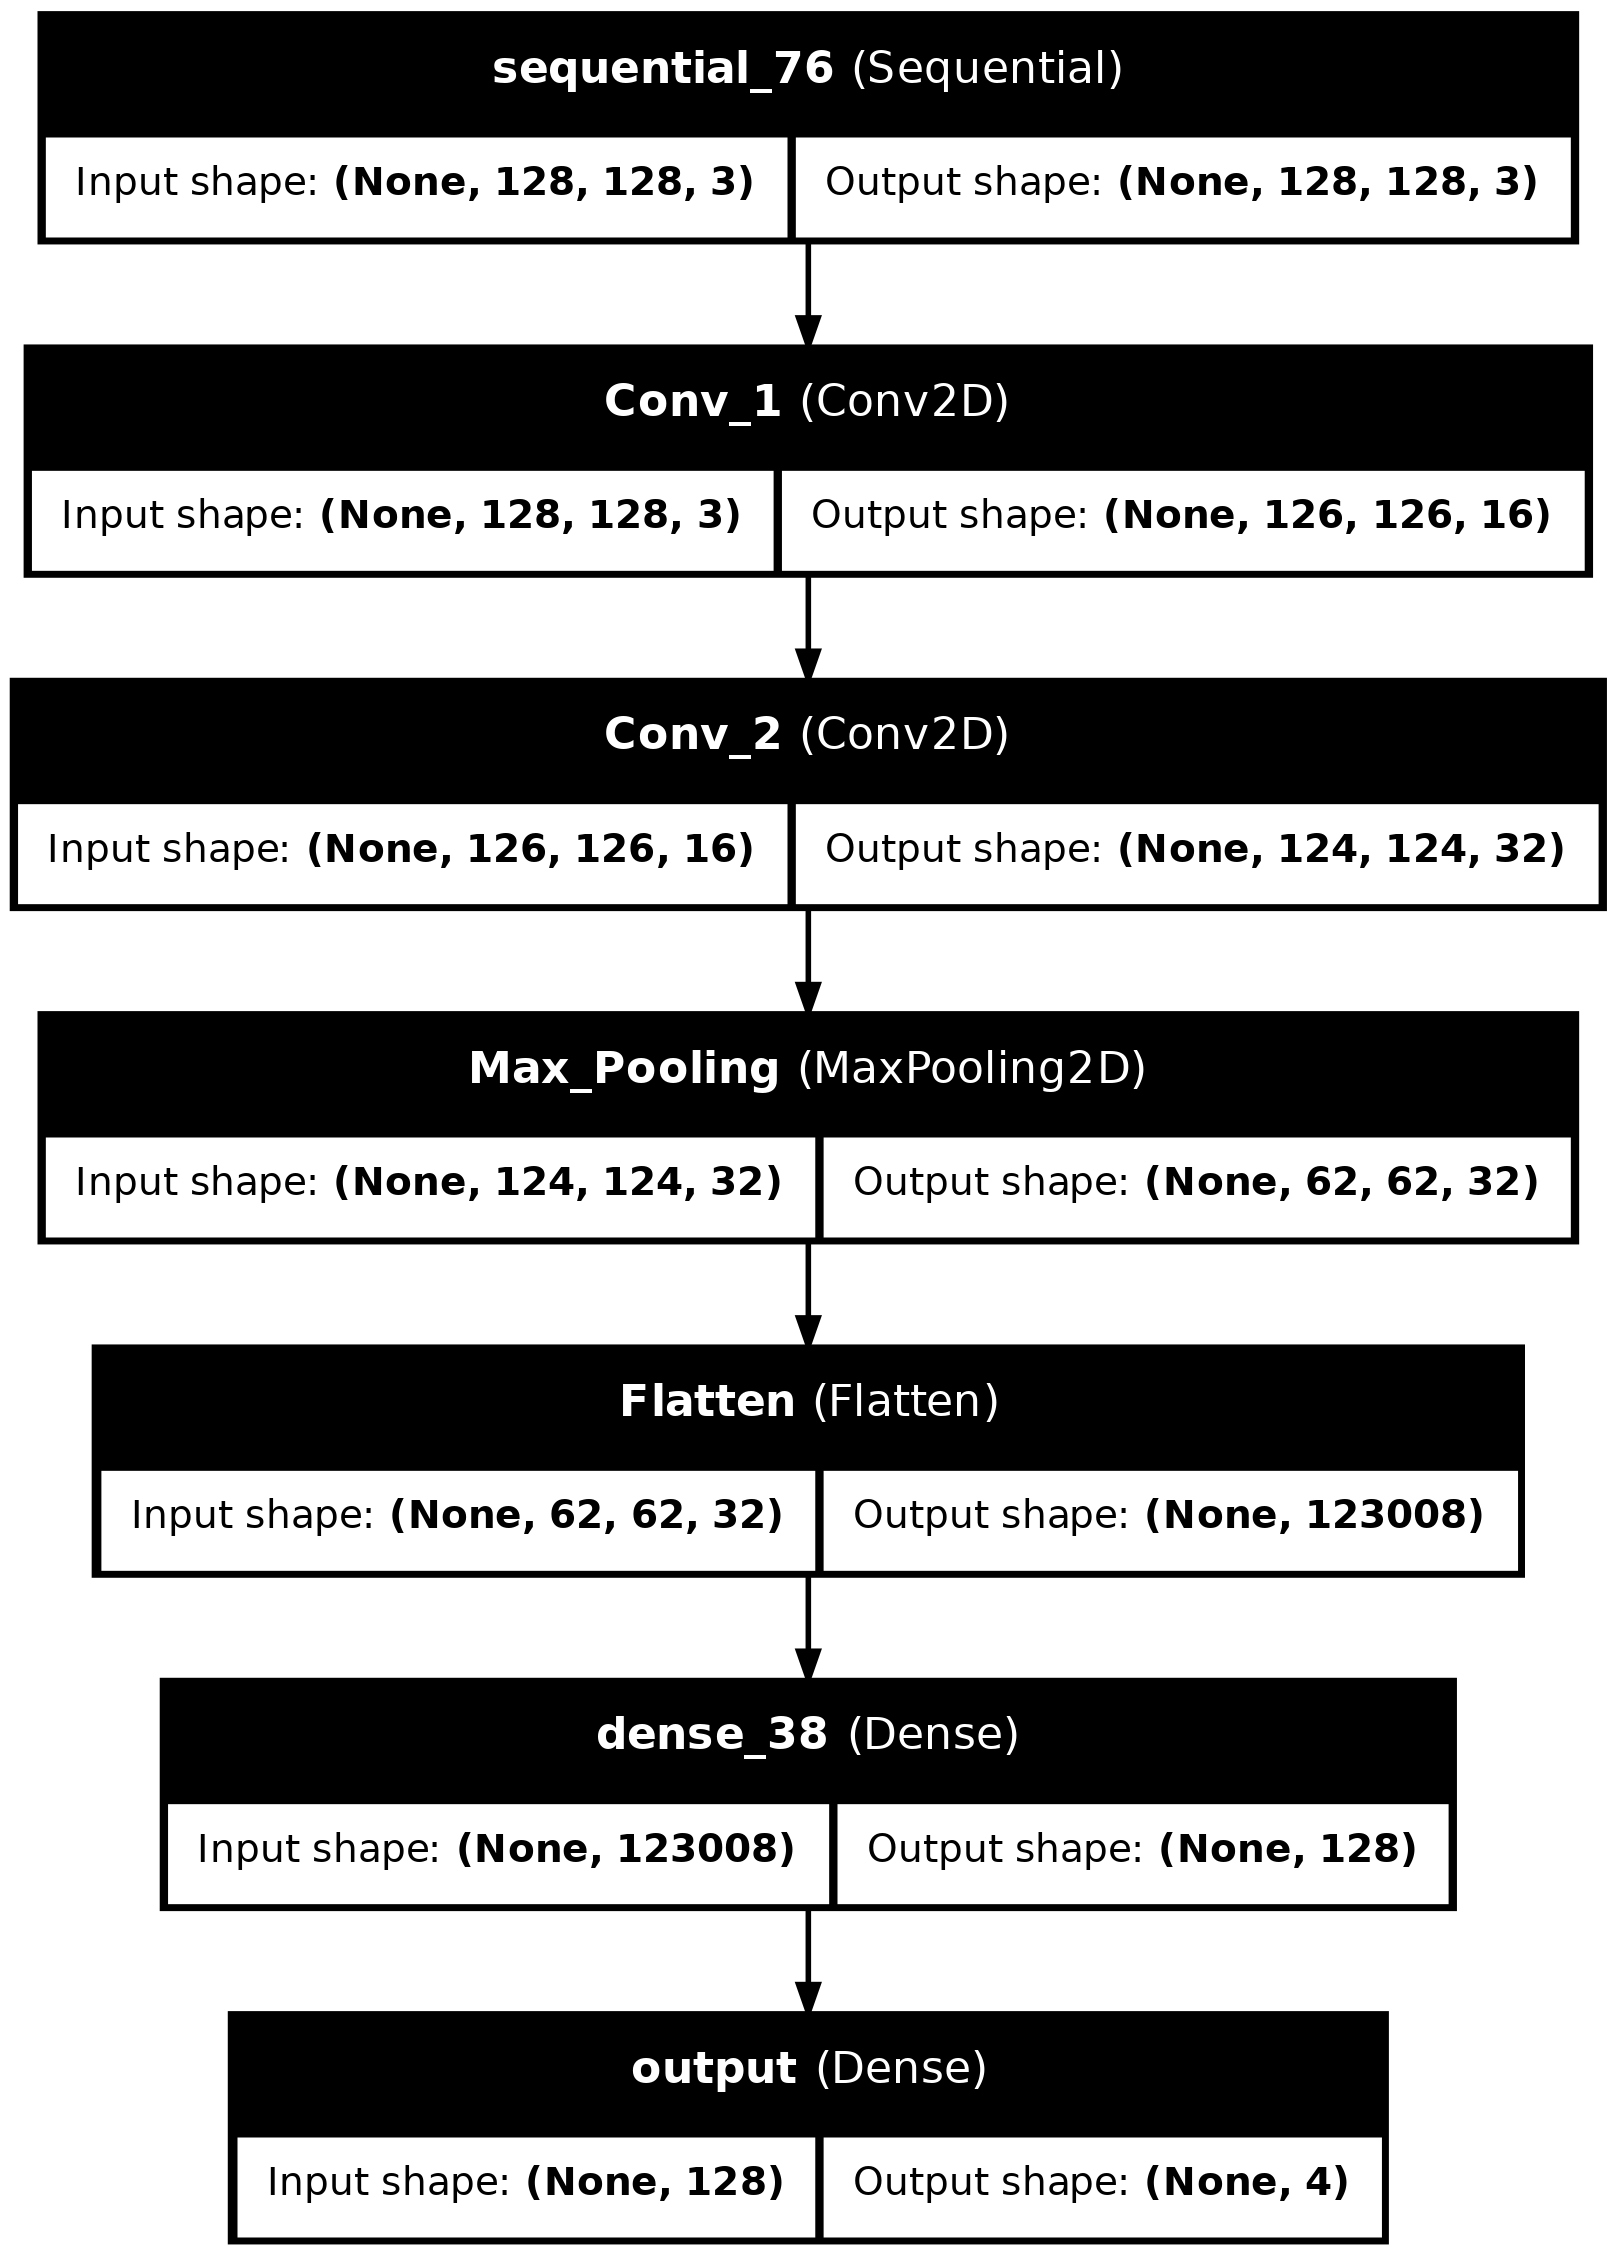

In [262]:
utils.plot_model(
    conv_model,
    show_shapes = True,
    show_layer_names = True
)

In [263]:
conv_model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Keras utils plot model

In [264]:

model_storage = './checkpoints'
if not path.exists(model_storage):
    makedirs(model_storage)
model_name = 'img_classificator.keras'

stopping = EarlyStopping(monitor='val_accuracy', patience=10)

model_checkpoint_callback = ModelCheckpoint(
    filepath=f'{model_storage}/{model_name}',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    
    )

In [265]:
history = conv_model.fit(
    train_dataset,
    #steps_per_epoch = 5,
    validation_data = validation_dataset,
    #validation_steps = 5
    epochs = 50,
    callbacks = [stopping,
                  model_checkpoint_callback]
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.2934 - loss: 1.5464 - val_accuracy: 0.3429 - val_loss: 1.4453
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.2658 - loss: 1.5172 - val_accuracy: 0.3143 - val_loss: 1.3418
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4584 - loss: 1.3163 - val_accuracy: 0.2857 - val_loss: 1.3242
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.3618 - loss: 1.2680 - val_accuracy: 0.3143 - val_loss: 1.3360
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.4411 - loss: 1.2331 - val_accuracy: 0.4000 - val_loss: 1.2737
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.4971 - loss: 1.1936 - val_accuracy: 0.4286 - val_loss: 1.2272
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5598 - loss: 1.1150 - val_accuracy: 0.2857 - val_loss: 1.2326
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5437 - loss: 1.1319 - val_accuracy: 0.3714 - val_loss:

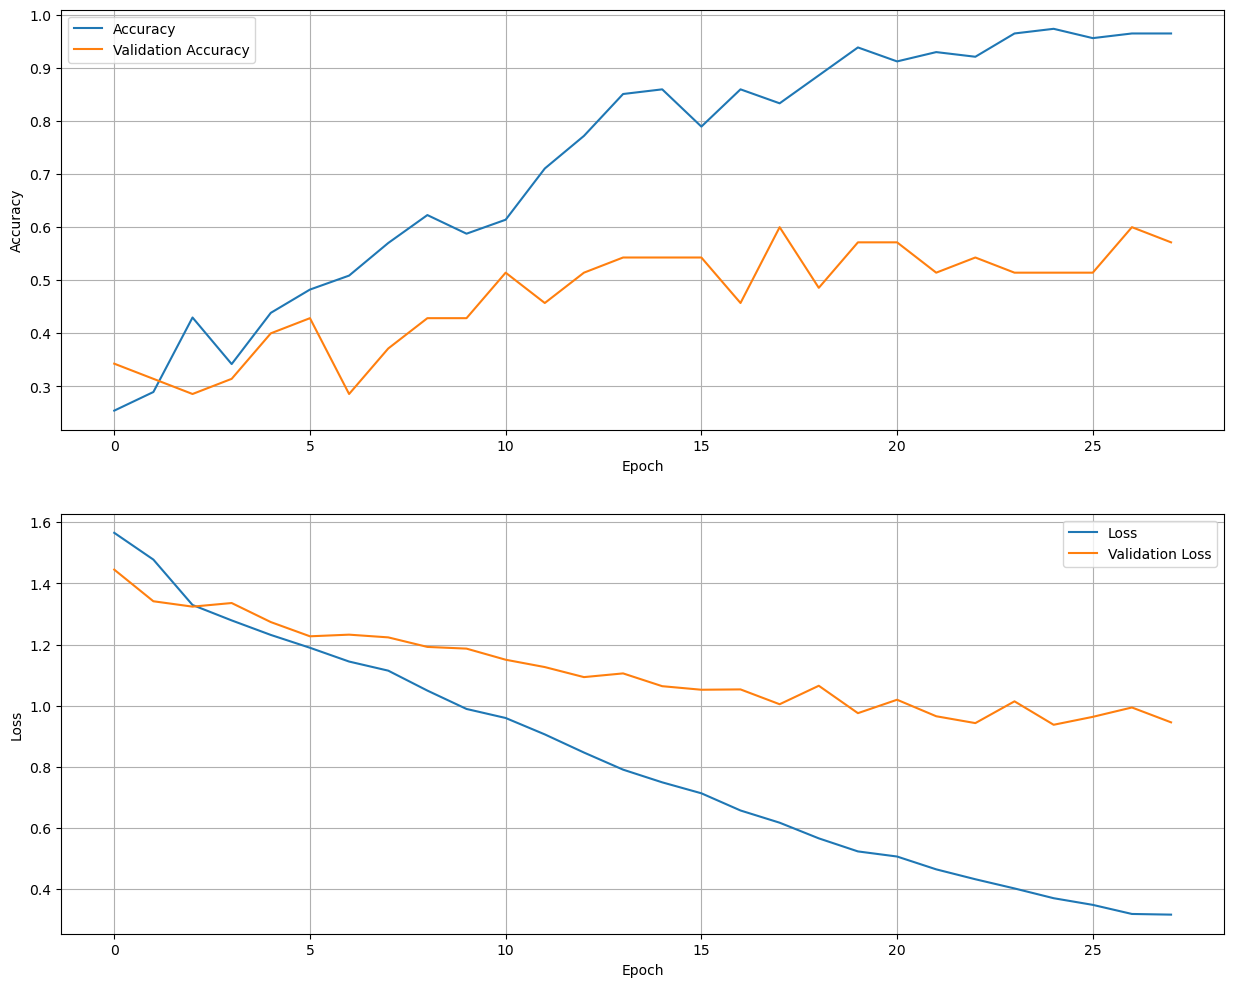

In [266]:
fig, (pr1, pr2) = plot.subplots(2, 1, figsize=(15, 12))
pr1.plot(history.history['accuracy'], label = 'Accuracy')
pr1.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
pr1.set_xlabel('Epoch')
pr1.legend()
pr1.set_ylabel('Accuracy')
pr1.grid()

pr2.plot(history.history['loss'], label = 'Loss')
pr2.plot(history.history['val_loss'], label = 'Validation Loss')
pr2.set_xlabel('Epoch')
pr2.legend()
pr2.set_ylabel('Loss')
pr2.grid()

plot.show()

In [267]:

#conv_model.save(filepath=f'{model_storage}/{model_name}')

In [268]:
def predict_image(image_path, model, class_names):
    # load and scale image first within the function
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)  
    image = image.resize(image_shape)

    image_as_array = img_to_array(image)
    image_as_array = np.expand_dims(image_as_array, axis=0)
    # Rescale image fed to model
    image_as_array /= 255.0
    predict_image_class = model.predict(image_as_array)
    predicted_class = class_names[np.argmax(predict_image_class)] 
    print(predicted_class)
    return image, predicted_class

# Create function to plot prediction result
def predict_and_plot_images(image_paths, model, class_names):
    plot.figure(figsize=(12, 8))
    for i, img in enumerate(image_paths, start=1):
        image, predicted_class = predict_image(img, model, class_names)
        plot.subplot(3, 3, i)
        plot.imshow(image)
        
        plot.title(f'Predicted Class: {predicted_class}')
        plot.axis('off')
    plot.tight_layout()
    plot.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
G
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
K
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
K
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
K


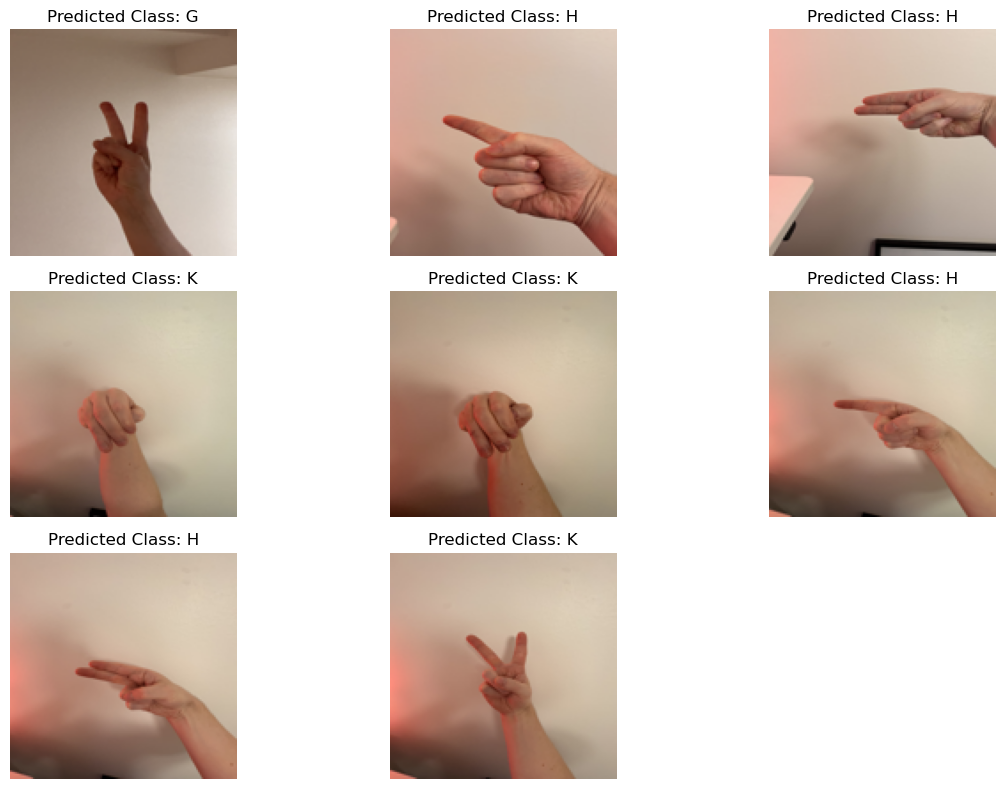

In [269]:
image_paths = [
    './test_images/IMG_2014.jpeg',
    './test_images/IMG_2015.jpeg',
    './test_images/IMG_2016.jpeg',
    './test_images/IMG_2018.jpeg',
    './test_images/IMG_2017.jpeg',
    './test_images/IMG_2019.jpeg',
    './test_images/IMG_2020.jpeg',
    './test_images/IMG_2021.jpeg'
]
imported_classificator = load_model(f'{model_storage}/{model_name}')
predict_and_plot_images(image_paths, imported_classificator, subfolders)